# Defining and Loading Model
In this notebook we will download and apply our pretrained Attention U-Net to an example image.

The example data we will be using is taken from [Emma Biondetti's GitHub](https://github.com/emmabiondetti/substantia-nigra-neuromelanin).

[Model repository](https://huggingface.co/lillepeder/SNceg-0.1).

## Import libraries

In [1]:
import nibabel as nib

from pathlib import Path
from nibabel.processing import conform
from fastMONAI.vision_all import load_learner, load_variables, inference
from huggingface_hub import snapshot_download

## Load image

In [2]:
base_dir = Path('../data/').absolute().resolve()

# SELECT INPUT FILE
fn = base_dir / 'mean_NM.nii.gz'
print(fn)

nimg = nib.load(fn)
print(nimg.shape, '\n', nimg.header.get_zooms())

/home/peder/Documents/repos/snceg/data/mean_NM.nii.gz
(176, 232, 256) 
 (1.0, 1.0, 1.0)


## A quick note on resampling

Although resampling is part of the image reader, we have observed that the model often fails on images whose size and resolution differ from the ones our model was trained on:
$(288 \times 384 \times 48)$ and anisotropic resolution: 
$(0.677 \times 0.677 \times 1.340) mm³$.

Therefore we first preprocess the image to fit the template prior to loading.

In [3]:
target_shape = (288,384, 48)
target_res = (.677, .677, 1.34)

In [4]:
# Resample
resampled_nimg = conform(nimg, target_shape, target_res)

# Save output
out_name = f"{fn.parent / fn.stem}_RESAMPLED.nii.gz"
resampled_nimg.to_filename(out_name)

print(out_name)

/home/peder/Documents/repos/snceg/data/mean_NM.nii_RESAMPLED.nii.gz


# Download the model from HuggingFace
The files are saved to `../models`

In [5]:
snapshot_download(repo_id="lillepeder/SNceg-0.1", local_dir='../models')

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

'/home/peder/Documents/repos/snceg/models'

# Load the model into memory
This step is made extremely easy by fastAI's `load_learner`:

In [6]:
model_fn = '../models/SNceg-0.1.pkl'
learner = load_learner(model_fn)

## Load some model variables

In [7]:
size, reorder, resample = load_variables(pkl_fn='../models/vars_SNceg-0.1.pkl')
print(size, reorder, resample)

[96, 96, 48] False [0.6667, 0.6667, 1.34]


# Predict
And just like that we can apply it to our input image.

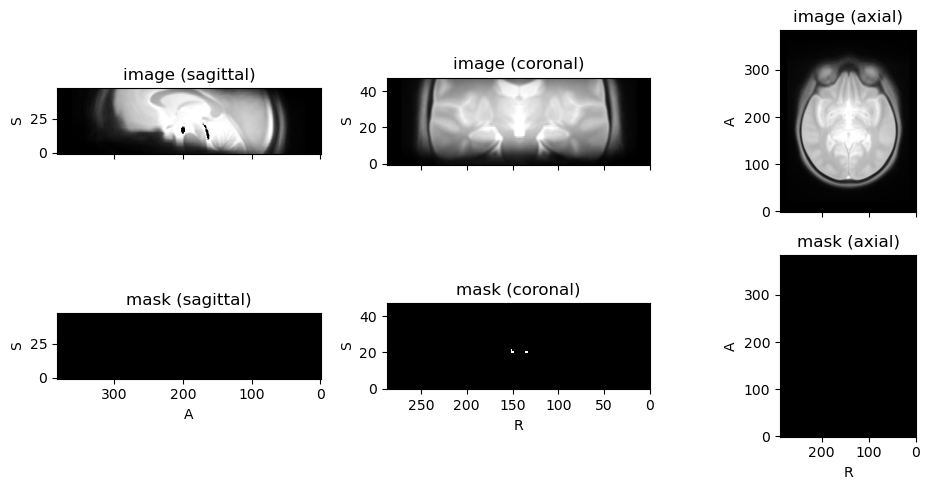

In [8]:
from torchio import Subject, ScalarImage, LabelMap

# DEFINE INPUT AND OUTPUT FILES
inp = out_name #'../data/atlas/average_nonlin_10.nii_RESAMPLED.nii.gz'
pred_fn = base_dir / f'predicted_mask.nii.gz'


# RUN PREDICTION
pred = inference(learner, reorder=reorder, resample=resample, fn=inp)


# SAVE AND PLOT
pred.save(pred_fn)

subject = Subject(image=ScalarImage(inp), mask=LabelMap(pred_fn))
subject.plot(figsize=(10,5))

Now you can view it in your viewer of choice, e.g. Freeview 

(to interrupt and resume the notebook, press `i` twice on your keyboard)

In [9]:
!freeview {inp} {pred_fn}:colormap=lut

niiRead(): detected input as 64 bit double, reading in as 32 bit float
niiRead(): detected input as 64 bit double, reading in as 32 bit float


# Resample back to native space
If we want the image back to original space, we can do this.

In [10]:
orig_shape = nimg.shape
orig_res = nimg.header.get_zooms()

print(orig_shape, orig_res)

(176, 232, 256) (1.0, 1.0, 1.0)


In [11]:
# Load mask
mask_img = nib.load(pred_fn)

# Resample to native space
native_mask = conform(mask_img, orig_shape, orig_res)

In [12]:
from nilearn import image

# threshold
bin_mask = image.math_img('img>0.5', img=native_mask)

# save
native_pred_fn = base_dir / f'predicted_mask_native.nii.gz'
bin_mask.to_filename(native_pred_fn)

In [14]:
!freeview {fn} {native_pred_fn}:colormap=lut

niiRead(): detected input as 64 bit double, reading in as 32 bit float
niiRead(): detected input as 64 bit double, reading in as 32 bit float


## Comment
The resampling may crop out part of the ROI, leaving us with an incomplete mask. If this is a problem, always look at your data, and consider using another resampling algorithm like AFNI's `3dresample`.